# Random Forest - Top model according to the SCPM of -2.62

In [1]:
%load_ext nb_black

<IPython.core.display.Javascript object>

In [2]:
# Database Reading and Manipulation
import pandas as pd

# Linear Algebra
import numpy as np

# Plotting
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns

# Model Selection
from sklearn.model_selection import train_test_split
from sklearn.model_selection import TimeSeriesSplit
from sklearn.model_selection import RepeatedKFold
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import cross_validate
from sklearn.model_selection import GridSearchCV

# Modeling
from sklearn.ensemble import RandomForestRegressor

# Metrics
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_absolute_percentage_error
from sklearn.metrics import r2_score

# Processing
from sklearn.preprocessing import StandardScaler


# Pipeline
from sklearn.pipeline import Pipeline

# Data imputation
from sklearn.impute import SimpleImputer

# Custom modules
## Model selection
from src.cross_validation.blocking_time_series_split import BlockingTimeSeriesSplit

## Function to print scores
from src.utils.print_scores import print_scores

## Function to calculate score regression metrics
from src.utils.score_regression_metrics import score_regression_metrics

## Function to fill the results metric dict
from src.utils.fill_results_dict import fill_results_dict

# Warnings
import warnings

<IPython.core.display.Javascript object>

# Functions and definitions

In [3]:
def get_random_forest_df_importances(scores):
    importances = {}
    importances_with_column = []
    columns = x.columns

    for index, pipeline in enumerate(scores["estimator"]):
        model = pipeline.named_steps["estimator"]
        importances[index] = model.feature_importances_

    for index, importances_vec in importances.items():
        importances_col = pd.DataFrame(
            {col: [c] for col, c in zip(columns, importances_vec)},
            index=[f"Importances - {index}"],
        )
        importances_with_column.append(importances_col)
    df_importances = pd.concat(importances_with_column)

    return df_importances

<IPython.core.display.Javascript object>

In [4]:
SEED = 47
METRICS = (
    "neg_root_mean_squared_error",
    "neg_mean_absolute_error",
    "neg_mean_absolute_percentage_error",
    "r2",
)
METRICS_DICT = {
    "neg_root_mean_squared_error": "RMSE",
    "neg_mean_absolute_error": "MAE",
    "neg_mean_absolute_percentage_error": "MAPE",
    "r2": "R2",
}

<IPython.core.display.Javascript object>

## Defining a dataframe structure to save the results

In [5]:
results_to_save = []

results_dict = {
    "Category": "Local Model",
    "Company": "209",
    "Plant": "S",
    "Features": "Chemical + Physical",
    "Data Shape": None,
    "Timesteps": None,
    "Model": "Random Forest",
    "Model Params": None,
    "Scaler": None,
    "Scaler Params": None,
    "Imputer": "Median",
    "Imputer Params": None,
    "Cross Validation": None,
    "Cross Validation Params": np.nan,
    "RMSE Train": np.nan,
    "MAE Train": np.nan,
    "MAPE Train": np.nan,
    "R2 Train": np.nan,
    "RMSE Test": np.nan,
    "MAE Test": np.nan,
    "MAPE Test": np.nan,
    "R2 Test": np.nan,
}

<IPython.core.display.Javascript object>

# Reading the dataset

In [6]:
df = pd.read_csv("../../../../data/processed/209/s.csv")

<IPython.core.display.Javascript object>

## Defining Features

In this set of experiments we keep only chemical and mineralogical features yielded by the same testing method/procedure

In [7]:
df_copy = df.copy().drop(["Cement_Type"], axis=1)

<IPython.core.display.Javascript object>

# 1. Decision Tree Regressor

In [8]:
PARAMS = {
    "criterion": "squared_error",
    "n_estimators": 5,
    "max_depth": 3,
    "random_state": SEED,
}

<IPython.core.display.Javascript object>

<h2>1. Dataset: df_no_cs</h2> <br>In this dataset the CS1, CS3  and CS7 variables are not considered. Only Chemical and mineralogical features measured by the same method. For this particular dataset, all chemical features, with the exception of LOI were measured by XRF and XRD methods.

In [9]:
y = df_copy.pop("CS28").values
x = df_copy.drop(["Date"], axis=1)
dates = df["Date"].copy()

x = x.reset_index(drop=True)
dates = dates.reset_index(drop=True)

<IPython.core.display.Javascript object>

## 1.3. Time Series Split Cross Validation

In [10]:
repeats = 3
n_splits = 5
gap = 0
pipeline = Pipeline(
    [
        ("imputer", SimpleImputer(strategy="median")),
        ("estimator", RandomForestRegressor(**PARAMS)),
    ]
)
cv = TimeSeriesSplit(gap=gap, max_train_size=None, n_splits=n_splits, test_size=None)

scores = cross_validate(
    pipeline,
    x,
    y,
    scoring=METRICS,
    cv=cv,
    n_jobs=-1,
    return_train_score=True,
    return_estimator=True,
    return_indices=True,
)
print("Time Series Split:")
print(f"Repeats: {repeats}")
print(f"n_splits: {n_splits}")
print()
print_scores(scores, METRICS, METRICS_DICT)

results_dict_copy = results_dict.copy()
results_dict_copy["Cross Validation"] = "Time Series Split"
results_dict_copy["Cross Validation Params"] = '{"N_Splits": 5, "Repeats": 1, "Gap": 0}'
results_dict_copy["Data Shape"] = x.shape
df_results = fill_results_dict(results_dict_copy, scores)
results_to_save.append(df_results)

Time Series Split:
Repeats: 3
n_splits: 5

******
[TRAIN]
******
RMSE: -0.616 (0.057)
MAE: -0.467 (0.043)
MAPE: -0.012 (0.001)
R2: 0.986 (0.003)


******
[TEST]
******
RMSE: -0.743 (0.084)
MAE: -0.557 (0.058)
MAPE: -0.014 (0.001)
R2: 0.979 (0.004)




<IPython.core.display.Javascript object>

## Plotting the Predictions

In [11]:
# Store predictions for each fold
all_predictions = []

for idx, pipeline in enumerate(scores["estimator"]):
    index_train = scores["indices"]["train"][idx]
    index_test = scores["indices"]["test"][idx]
    index_preds = np.concatenate([index_train, index_test])

    results = pipeline.predict(x.loc[index_preds])

    # Store predictions along with fold information
    fold_predictions = pd.DataFrame(
        {
            "DATE": dates[index_preds],
            "CS28": y[index_preds],
            "CS28_PRED": results,
            "SET": ["TRAIN"] * len(index_train) + ["TEST"] * len(index_test),
            "FOLD": [idx + 1] * len(index_preds),  # Indicate the fold number
        }
    )
    all_predictions.append(fold_predictions)

# Concatenate predictions from all folds
df_pred = pd.concat(all_predictions)
df_pred["DATE"] = pd.to_datetime(df_pred["DATE"])

<IPython.core.display.Javascript object>

In [12]:
df_pred[["DATE", "CS28", "CS28_PRED", "SET"]]

,DATE,CS28,CS28_PRED,SET
0,2021-01-02,34.200001,34.476539,TRAIN
1,2021-01-04,34.700001,34.942792,TRAIN
2,2021-01-04,46.099998,45.053179,TRAIN
3,2021-01-05,45.799999,45.579808,TRAIN
4,2021-01-05,34.599998,34.942792,TRAIN
...,...,...,...,...
1490,2023-07-15,46.500000,45.855037,TEST
1491,2023-07-18,46.500000,45.855037,TEST
1492,2023-07-18,34.400002,34.941689,TEST
1493,2023-07-19,46.099998,45.855037,TEST


<IPython.core.display.Javascript object>

In [13]:
df_pred

,DATE,CS28,CS28_PRED,SET,FOLD
0,2021-01-02,34.200001,34.476539,TRAIN,1
1,2021-01-04,34.700001,34.942792,TRAIN,1
2,2021-01-04,46.099998,45.053179,TRAIN,1
3,2021-01-05,45.799999,45.579808,TRAIN,1
4,2021-01-05,34.599998,34.942792,TRAIN,1
...,...,...,...,...,...
1490,2023-07-15,46.500000,45.855037,TEST,5
1491,2023-07-18,46.500000,45.855037,TEST,5
1492,2023-07-18,34.400002,34.941689,TEST,5
1493,2023-07-19,46.099998,45.855037,TEST,5


<IPython.core.display.Javascript object>

In [14]:
(df_pred["SET"] == "TEST").sum()

1245

<IPython.core.display.Javascript object>

In [15]:
df_pred["CS28"]

0       34.200001
1       34.700001
2       46.099998
3       45.799999
4       34.599998
          ...    
1490    46.500000
1491    46.500000
1492    34.400002
1493    46.099998
1494    34.099998
Name: CS28, Length: 4985, dtype: float64

<IPython.core.display.Javascript object>

In [16]:
df_copy_merge = df_copy.merge(df_pred, left_index=True, right_index=True, how="left")
df_copy_merge["COMPANY"] = 209
df_copy_merge["PLANT"] = "S"
for fold, (train_index, test_index) in enumerate(cv.split(x)):
    df_copy_merge.loc[train_index, "FOLD"] = fold + 1
    df_copy_merge.loc[test_index, "FOLD"] = fold + 1
df_copy_merge["FOLD"] = df_copy_merge["FOLD"].astype(int)
df_copy_merge.to_excel("local_model_random_forest_tsscv_209_s.xlsx", index=False)
df_copy_merge.to_csv("local_model_random_forest_tsscv_209_s.csv", index=False)

<IPython.core.display.Javascript object>

In [17]:
matplotlib.rc_file_defaults()

<IPython.core.display.Javascript object>

In [18]:
df[["CS28"]].describe().T

,count,mean,std,min,25%,50%,75%,max
CS28,1495.0,40.124488,5.250426,32.299999,34.799999,42.400002,45.099998,48.599998


<IPython.core.display.Javascript object>

In [19]:
df_copy_merge = df_copy.merge(df_pred, left_index=True, right_index=True, how="left")
df_copy_merge["COMPANY"] = 209
df_copy_merge["PLANT"] = "S"
for fold, (train_index, test_index) in enumerate(cv.split(x)):
    df_copy_merge.loc[train_index, "FOLD"] = fold + 1
    df_copy_merge.loc[test_index, "FOLD"] = fold + 1
df_copy_merge["FOLD"] = df_copy_merge["FOLD"].astype(int)
df_copy_merge.to_excel("local_model_random_forest_tsscv_209_s.xlsx", index=False)
df_copy_merge.to_csv("local_model_random_forest_tsscv_209_s.csv", index=False)

<IPython.core.display.Javascript object>

In [20]:
# # Store predictions for each fold
# all_predictions = []

# for idx, pipeline in enumerate(scores["estimator"]):
#     index_train = scores["indices"]["train"][idx]
#     index_test = scores["indices"]["test"][idx]
#     index_preds = np.concatenate([index_train, index_test])

#     results = pipeline.predict(x.loc[index_preds])

#     # Store predictions along with fold information
#     fold_predictions = pd.DataFrame(
#         {
#             "DATE": dates[index_preds],
#             "CS28": y[index_preds],
#             "CS28_PRED": results,
#             "SET": ["TRAIN"] * len(index_train) + ["TEST"] * len(index_test),
#             "FOLD": [idx + 1] * len(index_preds),  # Indicate the fold number
#         }
#     )
#     all_predictions.append(fold_predictions)

# # Concatenate predictions from all folds
# df_pred = pd.concat(all_predictions)
# df_pred["DATE"] = pd.to_datetime(df_pred["DATE"])

<IPython.core.display.Javascript object>

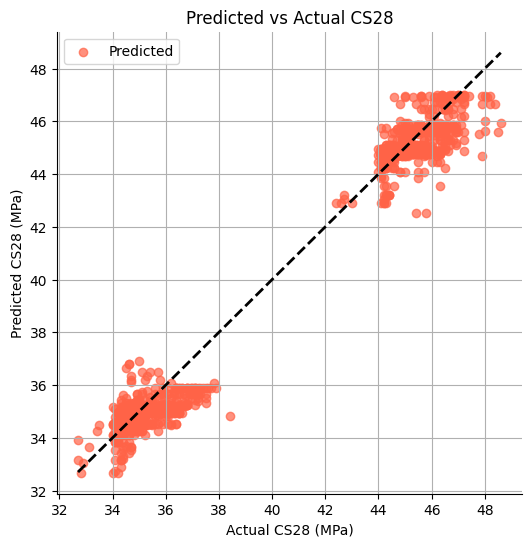

<IPython.core.display.Javascript object>

In [21]:
# Scatter plot of actual vs predicted values
test_data = df_pred[df_pred["SET"] == "TEST"]
plt.figure(figsize=(6, 6))
plt.scatter(
    test_data["CS28"],
    test_data["CS28_PRED"],
    color="tomato",
    alpha=0.7,
    label="Predicted",
)
plt.plot(
    [test_data["CS28"].min(), test_data["CS28"].max()],
    [test_data["CS28"].min(), test_data["CS28"].max()],
    color="black",
    linestyle="--",
    linewidth=2,
)
plt.xlabel("Actual CS28 (MPa)")
plt.ylabel("Predicted CS28 (MPa)")
plt.title("Predicted vs Actual CS28")
plt.legend()
plt.grid(True)
plt.gca().spines["top"].set_visible(False)
plt.gca().spines["right"].set_visible(False)

plt.savefig(
    "ecics_cm_p_cs_tiss_scpm_top_one_pred_vs_actual_cs28.png",
    dpi=300,
    bbox_inches="tight",
)
plt.show()

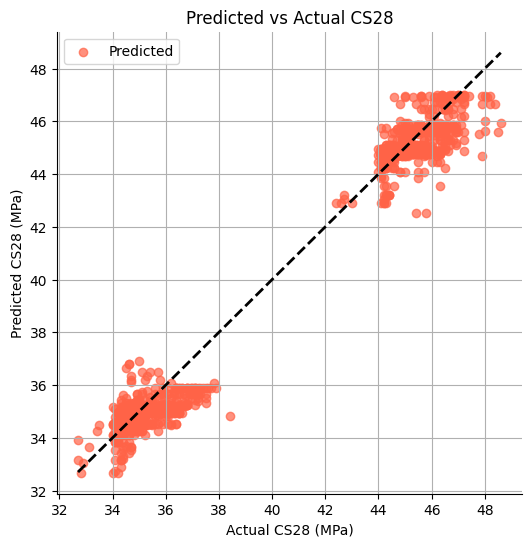

<IPython.core.display.Javascript object>

In [22]:
# Scatter plot of actual vs predicted values
test_data = df_pred[df_pred["SET"] == "TEST"]
plt.figure(figsize=(6, 6))
plt.scatter(
    test_data["CS28"],
    test_data["CS28_PRED"],
    color="tomato",
    alpha=0.7,
    label="Predicted",
)
plt.plot(
    [test_data["CS28"].min(), test_data["CS28"].max()],
    [test_data["CS28"].min(), test_data["CS28"].max()],
    color="black",
    linestyle="--",
    linewidth=2,
)
plt.xlabel("Actual CS28 (MPa)")
plt.ylabel("Predicted CS28 (MPa)")
plt.title("Predicted vs Actual CS28")
plt.legend()
plt.grid(True)
plt.gca().spines["top"].set_visible(False)
plt.gca().spines["right"].set_visible(False)

plt.savefig(
    "ecics_cm_p_cs_tiss_scpm_top_one_pred_vs_actual_cs28.png",
    dpi=300,
    bbox_inches="tight",
)
plt.show()

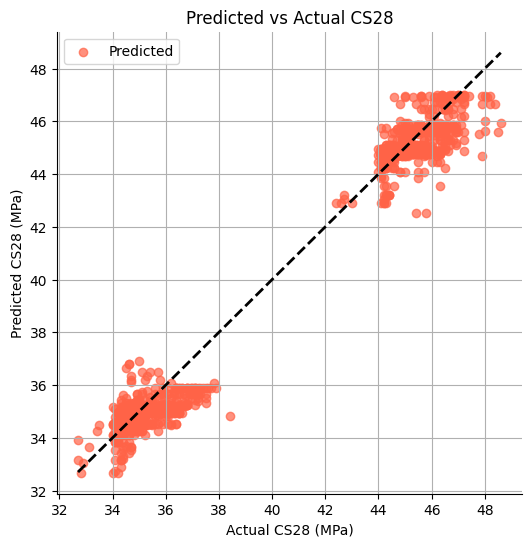

<IPython.core.display.Javascript object>

In [23]:
# Scatter plot of actual vs predicted values
test_data = df_pred[df_pred["SET"] == "TEST"]
plt.figure(figsize=(6, 6))
plt.scatter(
    test_data["CS28"],
    test_data["CS28_PRED"],
    color="tomato",
    alpha=0.7,
    label="Predicted",
)
plt.plot(
    [test_data["CS28"].min(), test_data["CS28"].max()],
    [test_data["CS28"].min(), test_data["CS28"].max()],
    color="black",
    linestyle="--",
    linewidth=2,
)
plt.xlabel("Actual CS28 (MPa)")
plt.ylabel("Predicted CS28 (MPa)")
plt.title("Predicted vs Actual CS28")
plt.legend()
plt.grid(True)
plt.gca().spines["top"].set_visible(False)
plt.gca().spines["right"].set_visible(False)

plt.savefig(
    "ecics_cm_p_cs_tiss_scpm_top_one_pred_vs_actual_cs28.png",
    dpi=300,
    bbox_inches="tight",
)
plt.show()

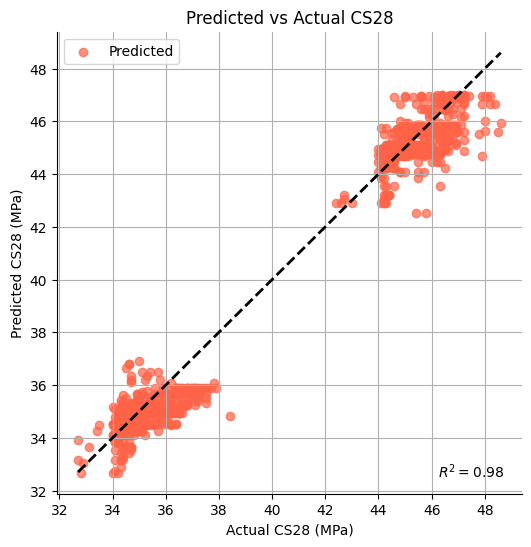

<IPython.core.display.Javascript object>

In [24]:
# Scatter plot of actual vs predicted values
test_data = df_pred[df_pred["SET"] == "TEST"]
plt.figure(figsize=(6, 6))
plt.scatter(
    test_data["CS28"],
    test_data["CS28_PRED"],
    color="tomato",
    alpha=0.7,
    label="Predicted",
)
plt.plot(
    [test_data["CS28"].min(), test_data["CS28"].max()],
    [test_data["CS28"].min(), test_data["CS28"].max()],
    color="black",
    linestyle="--",
    linewidth=2,
)
plt.xlabel("Actual CS28 (MPa)")
plt.ylabel("Predicted CS28 (MPa)")
plt.title("Predicted vs Actual CS28")
plt.legend()
plt.grid(True)
plt.gca().spines["top"].set_visible(False)
plt.gca().spines["right"].set_visible(False)

r2 = 0.98
plt.text(
    0.82,
    0.07,
    f"$R^2 = {r2:.2f}$",
    transform=plt.gca().transAxes,
    verticalalignment="top",
)

plt.savefig(
    "ecics_cm_p_cs_tiss_scpm_top_one_pred_vs_actual_cs28.png",
    dpi=300,
    bbox_inches="tight",
)
plt.show()

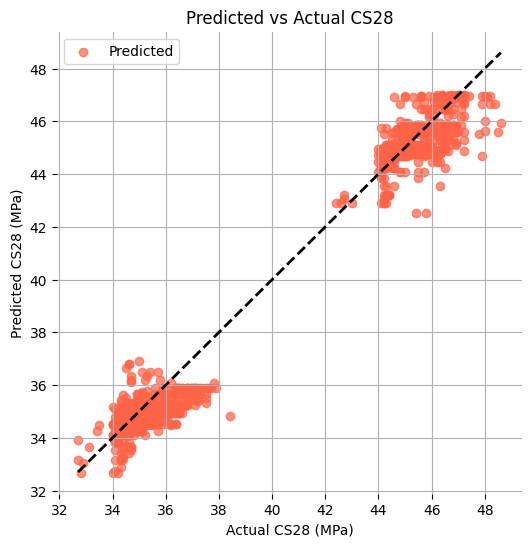

<IPython.core.display.Javascript object>

In [25]:
# Scatter plot of actual vs predicted values
test_data = df_pred[df_pred["SET"] == "TEST"]
plt.figure(figsize=(6, 6))
plt.scatter(
    test_data["CS28"],
    test_data["CS28_PRED"],
    color="tomato",
    alpha=0.7,
    label="Predicted",
)
plt.plot(
    [test_data["CS28"].min(), test_data["CS28"].max()],
    [test_data["CS28"].min(), test_data["CS28"].max()],
    color="black",
    linestyle="--",
    linewidth=2,
)
plt.xlabel("Actual CS28 (MPa)")
plt.ylabel("Predicted CS28 (MPa)")
plt.title("Predicted vs Actual CS28")
plt.legend()
plt.grid(True)
plt.gca().spines["top"].set_visible(False)
plt.gca().spines["right"].set_visible(False)
plt.gca().spines["bottom"].set_visible(False)
plt.gca().spines["left"].set_visible(False)

plt.show()

In [26]:
# # Reset indices to ensure alignment
# x = x.reset_index(drop=True)
# dates = dates.reset_index(drop=True)

# # Store predictions for each fold
# all_predictions = []

# for idx, pipeline in enumerate(scores["estimator"]):
#     index_train = scores["indices"]["train"][idx]
#     index_test = scores["indices"]["test"][idx]
#     index_preds = np.concatenate([index_train, index_test])

#     # Predict using x.iloc and standard indexing for y
#     results = pipeline.predict(x.iloc[index_preds])

#     # Store predictions along with fold information
#     fold_predictions = pd.DataFrame(
#         {
#             "DATE": dates.iloc[index_preds],
#             "CS28": y[index_preds],
#             "CS28_PRED": results,
#             "SET": ["TRAIN"] * len(index_train) + ["TEST"] * len(index_test),
#             "FOLD": [idx + 1] * len(index_preds),
#         }
#     )
#     all_predictions.append(fold_predictions)

# # Concatenate predictions from all folds
# df_pred = pd.concat(all_predictions, ignore_index=True)
# df_pred["DATE"] = pd.to_datetime(df_pred["DATE"])

# # Plotting
# test_data = df_pred[df_pred["SET"] == "TEST"]

# plt.figure(figsize=(6, 6))
# plt.scatter(
#     test_data["CS28"],
#     test_data["CS28_PRED"],
#     color="tomato",
#     alpha=0.7,
#     label="Predicted",
# )
# plt.plot(
#     [test_data["CS28"].min(), test_data["CS28"].max()],
#     [test_data["CS28"].min(), test_data["CS28"].max()],
#     color="black",
#     linestyle="--",
#     linewidth=2,
# )
# plt.xlabel("Actual CS28 (MPa)")
# plt.ylabel("Predicted CS28 (MPa)")
# plt.title("Predicted vs Actual CS28")
# plt.legend()
# plt.grid(True)
# plt.gca().spines["top"].set_visible(False)
# plt.gca().spines["right"].set_visible(False)

# plt.savefig(
#     "ecics_cm_p_cs_tiss_scpm_top_one_pred_vs_actual_cs28.png",
#     dpi=300,
#     bbox_inches="tight",
# )
# plt.show()


<IPython.core.display.Javascript object>

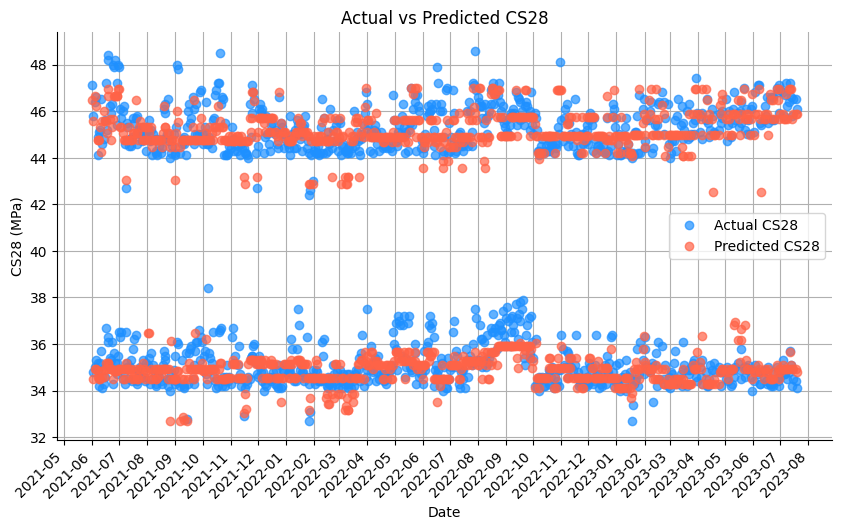

<IPython.core.display.Javascript object>

In [27]:
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

plt.figure(figsize=(10, 6))
plt.plot(
    test_data["DATE"],
    test_data["CS28"],
    color="dodgerblue",
    alpha=0.7,
    marker="o",
    linestyle="none",
    label="Actual CS28",
)
plt.plot(
    test_data["DATE"],
    test_data["CS28_PRED"],
    color="tomato",
    alpha=0.7,
    marker="o",
    linestyle="none",
    label="Predicted CS28",
)
plt.xlabel("Date")
plt.ylabel("CS28 (MPa)")
plt.title("Actual vs Predicted CS28")
plt.legend()
plt.grid(True)

# Improving x-axis readability
plt.gca().xaxis.set_major_locator(mdates.MonthLocator())  # Set ticks for each month
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))  # Format date as 'YYYY-MM-DD'
plt.gcf().autofmt_xdate(rotation=45)  # Rotate x-axis labels

plt.gca().spines["top"].set_visible(False)
plt.gca().spines["right"].set_visible(False)

plt.savefig(
    "ecics_cm_p_cs_tiss_scpm_top_one_pred_vs_actual_cs28_over_time.png",
    dpi=300,
    bbox_inches="tight",
)

plt.show()


In [28]:
len(test_data), 175 * 5

(1245, 875)

<IPython.core.display.Javascript object>

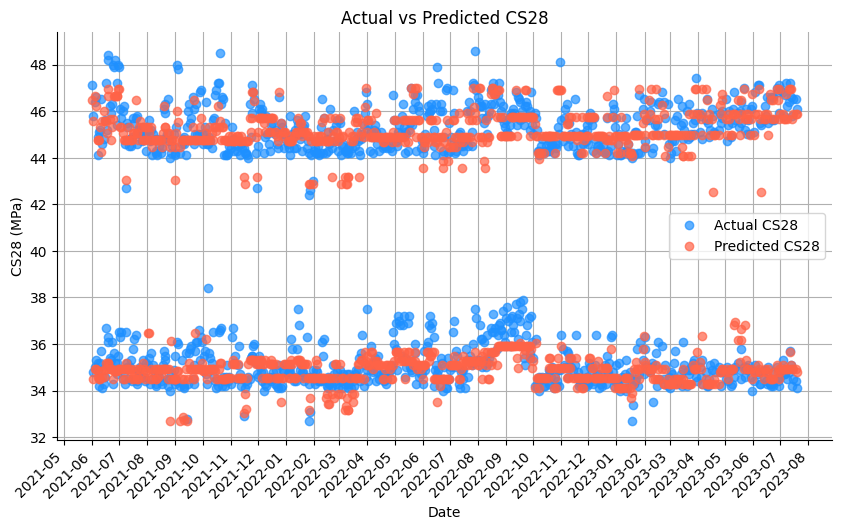

<IPython.core.display.Javascript object>

In [29]:
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

plt.figure(figsize=(10, 6))
plt.plot(
    test_data["DATE"],
    test_data["CS28"],
    color="dodgerblue",
    alpha=0.7,
    marker="o",
    linestyle="none",
    label="Actual CS28",
)
plt.plot(
    test_data["DATE"],
    test_data["CS28_PRED"],
    color="tomato",
    alpha=0.7,
    marker="o",
    linestyle="none",
    label="Predicted CS28",
)
plt.xlabel("Date")
plt.ylabel("CS28 (MPa)")
plt.title("Actual vs Predicted CS28")
plt.legend()
plt.grid(True)

# Improving x-axis readability
plt.gca().xaxis.set_major_locator(mdates.MonthLocator())  # Set ticks for each month
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))  # Format date as 'YYYY-MM-DD'
plt.gcf().autofmt_xdate(rotation=45)  # Rotate x-axis labels

plt.gca().spines["top"].set_visible(False)
plt.gca().spines["right"].set_visible(False)

plt.savefig(
    "ecics_cm_p_cs_tiss_scpm_top_one_pred_vs_actual_cs28_over_time.png",
    dpi=300,
    bbox_inches="tight",
)

plt.show()


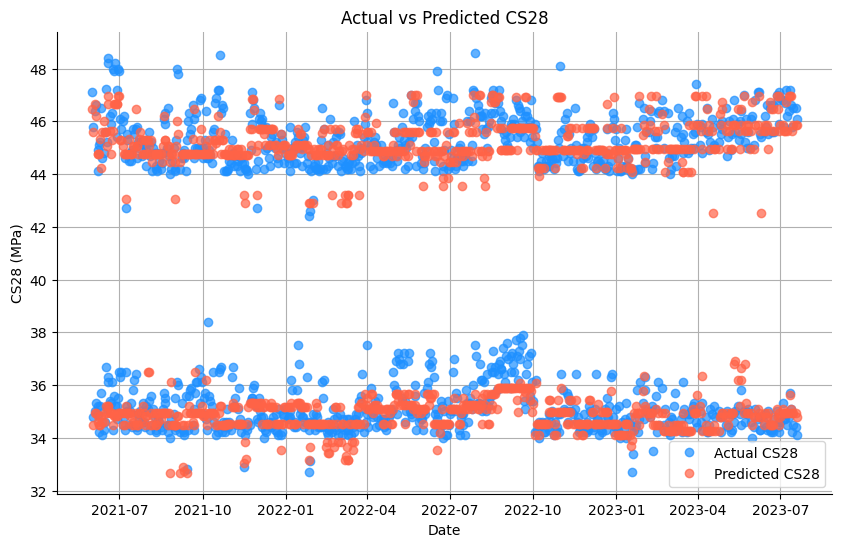

<IPython.core.display.Javascript object>

In [30]:
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

plt.figure(figsize=(10, 6))
plt.plot(
    test_data["DATE"],
    test_data["CS28"],
    color="dodgerblue",
    alpha=0.7,
    marker="o",
    linestyle="none",
    label="Actual CS28",
)
plt.plot(
    test_data["DATE"],
    test_data["CS28_PRED"],
    color="tomato",
    alpha=0.7,
    marker="o",
    linestyle="none",
    label="Predicted CS28",
)
plt.xlabel("Date")
plt.ylabel("CS28 (MPa)")
plt.title("Actual vs Predicted CS28")
plt.legend()
plt.grid(True)

# Improving x-axis readability
# plt.gca().xaxis.set_major_locator(mdates.MonthLocator())  # Set ticks for each month
# plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))  # Format date as 'YYYY-MM-DD'
# plt.gcf().autofmt_xdate(rotation=45)  # Rotate x-axis labels

plt.gca().spines["top"].set_visible(False)
plt.gca().spines["right"].set_visible(False)

plt.savefig(
    "ecics_cm_p_cs_tiss_scpm_top_one_pred_vs_actual_cs28_over_time.png",
    dpi=300,
    bbox_inches="tight",
)

plt.show()

In [31]:
std_lower = []
std_higher = []

for train_idx, test_idx in cv.split(x):
    lower_range = y[train_idx][y[train_idx] < 40].std()
    higher_range = y[train_idx][y[train_idx] >= 40].std()
    std_lower.append(lower_range)
    std_higher.append(higher_range)

<IPython.core.display.Javascript object>

In [32]:
sorted(std_lower)

[0.8653155048478429,
 0.9097882748958598,
 0.9188149837665851,
 0.9326987346042488,
 0.9634727846622673]

<IPython.core.display.Javascript object>

In [33]:
sorted(std_higher)

[1.0255253177217556,
 1.0681758622345205,
 1.0851354452048008,
 1.1546930923717666,
 1.1797855102654864]

<IPython.core.display.Javascript object>

In [34]:
df_pred["CS28"][(df_pred["CS28"] < 38) & (df_pred["SET"] == "TRAIN")].describe()

count    1868.000000
mean       34.849304
std         0.924802
min        32.299999
25%        34.400002
50%        34.700001
75%        35.299999
max        37.900002
Name: CS28, dtype: float64

<IPython.core.display.Javascript object>

In [35]:
df_pred["CS28"][(df_pred["CS28"] > 44) & (df_pred["SET"] == "TRAIN")].describe()

count    1785.000000
mean       45.269434
std         0.982003
min        44.099998
25%        44.500000
50%        45.000000
75%        45.900002
max        48.599998
Name: CS28, dtype: float64

<IPython.core.display.Javascript object>

## Assessing Feature Importance

In [36]:
df_importances = get_random_forest_df_importances(scores)

<IPython.core.display.Javascript object>

In [37]:
df_importances

,Free CaO,CaO,MgO,Na2O,Al2O3,SiO2,SO3,K2O,Fe2O3,Loss on Ignition,Insoluble Residue,Blaine,#400,Initial setting time,Final setting time,CS3,CS7
Importances - 0,0.000000,0.000000,0.000067,0.0,0.000027,0.194327,0.000000,0.000134,0.0,0.0,0.194799,0.000013,0.194163,0.0,0.000000,0.200455,0.216014
Importances - 1,0.000748,0.000000,0.000000,0.0,0.000000,0.000000,0.000087,0.000000,0.0,0.0,0.000000,0.000000,0.195264,0.0,0.000151,0.586082,0.217668
Importances - 2,0.000278,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.000021,0.000000,0.195954,0.0,0.000000,0.587085,0.216662
Importances - 3,0.000000,0.000124,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.000000,0.000000,0.196210,0.0,0.000105,0.587733,0.215829
Importances - 4,0.000000,0.000288,0.000000,0.0,0.000000,0.000420,0.000000,0.000000,0.0,0.0,0.000000,0.000000,0.195681,0.0,0.000000,0.587657,0.215953


<IPython.core.display.Javascript object>

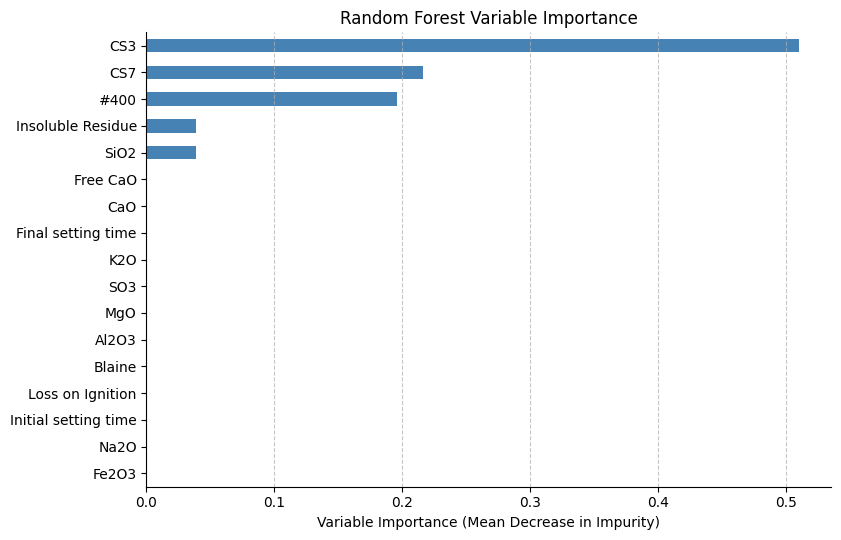

<IPython.core.display.Javascript object>

In [38]:
df_importances.mean(axis=0).sort_values().plot(
    kind="barh", figsize=(10, 5.5), color="steelblue"  # Consider using 'steelblue'
)
plt.title("Random Forest Variable Importance")
plt.xlabel("Variable Importance (Mean Decrease in Impurity)")
plt.grid(axis="x", linestyle="--", alpha=0.7)
plt.gca().spines["top"].set_visible(False)
plt.gca().spines["right"].set_visible(False)
plt.tight_layout()
plt.subplots_adjust(left=0.3)
plt.show()

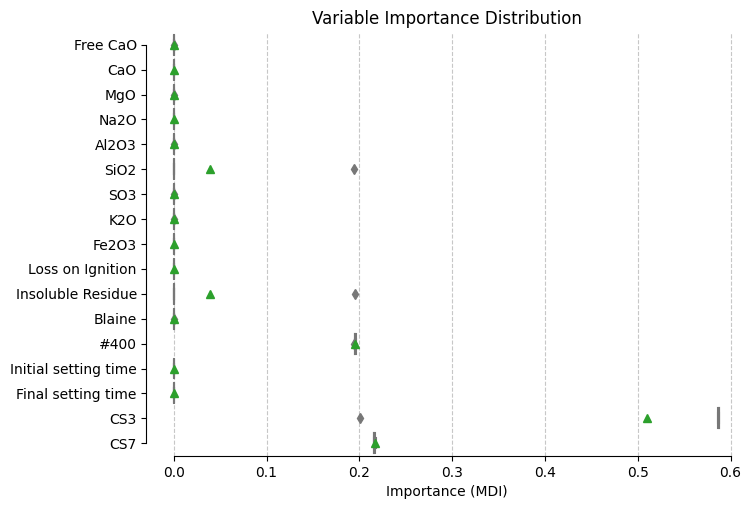

<IPython.core.display.Javascript object>

In [39]:
warnings.filterwarnings("ignore")
plt.figure(figsize=(10, 5.5))
sns.boxplot(data=df_importances, orient="h", color="lightsteelblue", saturation=0.7, showmeans=True)
sns.despine(trim=True, left=False)
plt.xlabel("Importance (MDI)")
plt.title("Variable Importance Distribution")
plt.grid(axis='x', linestyle='--', alpha=0.7)
plt.subplots_adjust(left=0.3)
plt.show()


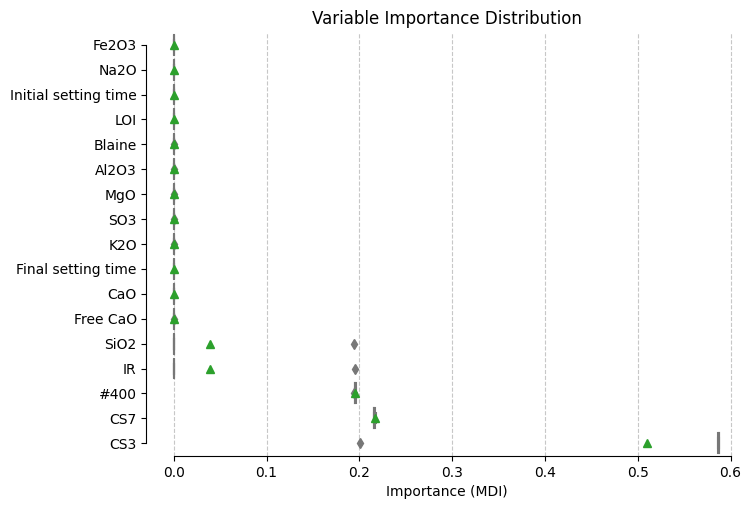

<IPython.core.display.Javascript object>

In [40]:
# Calculate the means of the importance scores
mean_importances = df_importances.mean()

# Sort the features by their mean relevance
sorted_features = mean_importances.sort_values()

# Re-order the DataFrame according to the sorted features
df_importances_sorted = df_importances[sorted_features.index]

# Plot the sorted boxplot
df_importances_sorted = df_importances_sorted.rename(
    columns={"Loss on Ignition": "LOI", "Insoluble Residue": "IR"}
)

plt.figure(figsize=(10, 5.5))
sns.boxplot(
    data=df_importances_sorted,
    orient="h",
    color="lightsteelblue",
    saturation=1,
    showmeans=True,
)
sns.despine(trim=True, left=False)
plt.xlabel("Importance (MDI)")
plt.title("Variable Importance Distribution")
plt.grid(axis="x", linestyle="--", alpha=0.7)
plt.subplots_adjust(left=0.3)
plt.savefig(
    "ecics_cm_p_cs_tiss_random_forest_scpm_best_dist_var_relevance.png",
    dpi=300,
    bbox_inches="tight",
)
plt.show()

In [41]:
print("Default font family:", matplotlib.rcParams["font.family"])
print("Default sans-serif fonts:", matplotlib.rcParams["font.sans-serif"])
print("Default font size:", matplotlib.rcParams["font.size"])
print("Default font weight:", matplotlib.rcParams["font.weight"])

Default font family: ['sans-serif']
Default sans-serif fonts: ['DejaVu Sans', 'Bitstream Vera Sans', 'Computer Modern Sans Serif', 'Lucida Grande', 'Verdana', 'Geneva', 'Lucid', 'Arial', 'Helvetica', 'Avant Garde', 'sans-serif']
Default font size: 10.0
Default font weight: normal


<IPython.core.display.Javascript object>

In [42]:
plt.get_backend()

'module://matplotlib_inline.backend_inline'

<IPython.core.display.Javascript object>

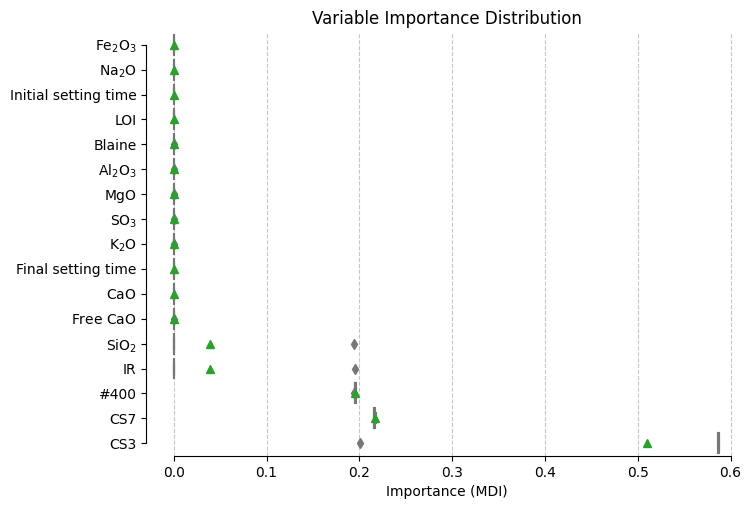

<IPython.core.display.Javascript object>

In [43]:
# Backup the original backend
original_backend = plt.get_backend()

# Use Matplotlib's default backend
# plt.switch_backend("agg")  # or any backend you prefer

# Update font settings to default
plt.rcParams.update(
    {
        "font.family": "sans-serif",
        "font.sans-serif": ["DejaVu Sans"],
        "font.size": 10,
        "text.usetex": False,  # Use MathText, not LaTeX
    }
)

# plt.rcParams.update(
#     {
#         "mathtext.fontset": "custom",
#         "mathtext.rm": "DejaVu Sans",
#         "mathtext.it": "DejaVu Sans:italic",
#         "mathtext.bf": "DejaVu Sans:bold",
#     }
# )


# Convert chemical formulas using MathText syntax
df_importances_sorted_plot = df_importances_sorted.rename(
    columns={
        "K2O": r"$\mathrm{K_2O}$",
        "Free CaO": r"Free $\mathrm{CaO}$",
        "Total C2S": r"Total $\mathrm{C_2S}$",
        "Na2O": r"$\mathrm{Na_2O}$",
        "CaO": r"$\mathrm{CaO}$",
        "SiO2": r"$\mathrm{SiO_2}$",
        "MgO": r"$\mathrm{MgO}$",
        "Fe2O3": r"$\mathrm{Fe_2O_3}$",
        "Al2O3": r"$\mathrm{Al_2O_3}$",
        "Total C3S": r"Total $\mathrm{C_3S}$",
        "C3A": r"$\mathrm{C_3A}$",
        "C4AF": r"$\mathrm{C_4AF}$",
        "LOI": "LOI",
        "SO3": r"$\mathrm{SO_3}$",
        "Insoluble Residue": "IR",
    }
)

plt.figure(figsize=(10, 5.5))
sns.boxplot(
    data=df_importances_sorted_plot,
    orient="h",
    color="lightsteelblue",
    saturation=1,
    showmeans=True,
)
sns.despine(trim=True, left=False)
plt.xlabel("Importance (MDI)")
plt.title("Variable Importance Distribution")
plt.grid(axis="x", linestyle="--", alpha=0.7)
plt.subplots_adjust(left=0.3)
plt.savefig(
    "ecics_cm_p_cs_tiss_random_forest_scpm_best_dist_var_relevance.png",
    dpi=300,
    bbox_inches="tight",
)
plt.show()


# Step 3: Reset all rcParams to their default values
matplotlib.rcParams.update(matplotlib.rcParamsDefault)
plt.rcdefaults()

# Switch back to the original backend
plt.switch_backend(original_backend)

In [44]:
df_importances

,Free CaO,CaO,MgO,Na2O,Al2O3,SiO2,SO3,K2O,Fe2O3,Loss on Ignition,Insoluble Residue,Blaine,#400,Initial setting time,Final setting time,CS3,CS7
Importances - 0,0.000000,0.000000,0.000067,0.0,0.000027,0.194327,0.000000,0.000134,0.0,0.0,0.194799,0.000013,0.194163,0.0,0.000000,0.200455,0.216014
Importances - 1,0.000748,0.000000,0.000000,0.0,0.000000,0.000000,0.000087,0.000000,0.0,0.0,0.000000,0.000000,0.195264,0.0,0.000151,0.586082,0.217668
Importances - 2,0.000278,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.000021,0.000000,0.195954,0.0,0.000000,0.587085,0.216662
Importances - 3,0.000000,0.000124,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.000000,0.000000,0.196210,0.0,0.000105,0.587733,0.215829
Importances - 4,0.000000,0.000288,0.000000,0.0,0.000000,0.000420,0.000000,0.000000,0.0,0.0,0.000000,0.000000,0.195681,0.0,0.000000,0.587657,0.215953


<IPython.core.display.Javascript object>

In [45]:
df_importances.describe().T

,count,mean,std,min,25%,50%,75%,max
Free CaO,5.0,0.000205,0.000326,0.000000,0.000000,0.000000,0.000278,0.000748
CaO,5.0,0.000082,0.000127,0.000000,0.000000,0.000000,0.000124,0.000288
MgO,5.0,0.000013,0.000030,0.000000,0.000000,0.000000,0.000000,0.000067
Na2O,5.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
Al2O3,5.0,0.000005,0.000012,0.000000,0.000000,0.000000,0.000000,0.000027
SiO2,5.0,0.038950,0.086859,0.000000,0.000000,0.000000,0.000420,0.194327
SO3,5.0,0.000017,0.000039,0.000000,0.000000,0.000000,0.000000,0.000087
K2O,5.0,0.000027,0.000060,0.000000,0.000000,0.000000,0.000000,0.000134
Fe2O3,5.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
Loss on Ignition,5.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000


<IPython.core.display.Javascript object>

In [46]:
df_importances.mean(axis=0)

Free CaO                0.000205
CaO                     0.000082
MgO                     0.000013
Na2O                    0.000000
Al2O3                   0.000005
SiO2                    0.038950
SO3                     0.000017
K2O                     0.000027
Fe2O3                   0.000000
Loss on Ignition        0.000000
Insoluble Residue       0.038964
Blaine                  0.000003
#400                    0.195454
Initial setting time    0.000000
Final setting time      0.000051
CS3                     0.509802
CS7                     0.216425
dtype: float64

<IPython.core.display.Javascript object>

In [47]:
df_importances.std(axis=0)

Free CaO                0.000326
CaO                     0.000127
MgO                     0.000030
Na2O                    0.000000
Al2O3                   0.000012
SiO2                    0.086859
SO3                     0.000039
K2O                     0.000060
Fe2O3                   0.000000
Loss on Ignition        0.000000
Insoluble Residue       0.087114
Blaine                  0.000006
#400                    0.000803
Initial setting time    0.000000
Final setting time      0.000072
CS3                     0.172931
CS7                     0.000766
dtype: float64

<IPython.core.display.Javascript object>

In [48]:
df_importances.std(axis=0, ddof=0)

Free CaO                0.000292
CaO                     0.000113
MgO                     0.000027
Na2O                    0.000000
Al2O3                   0.000011
SiO2                    0.077689
SO3                     0.000035
K2O                     0.000054
Fe2O3                   0.000000
Loss on Ignition        0.000000
Insoluble Residue       0.077917
Blaine                  0.000005
#400                    0.000718
Initial setting time    0.000000
Final setting time      0.000064
CS3                     0.154675
CS7                     0.000685
dtype: float64

<IPython.core.display.Javascript object>

In [49]:
df_copy.nunique()

Date                     751
Free CaO                 184
CaO                     1339
MgO                     1007
Na2O                     167
Al2O3                    874
SiO2                    1207
SO3                      513
K2O                      572
Fe2O3                    602
Loss on Ignition         341
Insoluble Residue        570
Blaine                   116
#400                     448
Initial setting time      67
Final setting time        99
CS3                      124
CS7                      145
dtype: int64

<IPython.core.display.Javascript object>

In [50]:
pipeline.named_steps

{'imputer': SimpleImputer(strategy='median'),
 'estimator': RandomForestRegressor(max_depth=3, n_estimators=5, random_state=47)}

<IPython.core.display.Javascript object>

In [51]:
from sklearn.inspection import permutation_importance

<IPython.core.display.Javascript object>

In [52]:
# Initialize lists to store importance results
mdi_importances = []
perm_importances = []

# Compute feature importances
for i, (train_idx, test_idx) in enumerate(cv.split(x, y)):
    pipeline.fit(x.iloc[train_idx], y[train_idx])

    # Extract the trained model
    model = pipeline.named_steps["estimator"]
    imputer = pipeline.named_steps["imputer"]
    # Compute MDI importance
    mdi_importances.append(model.feature_importances_)

    # Compute permutation importance
    result = permutation_importance(
        model,
        imputer.transform(x.iloc[test_idx]),
        y[test_idx],
        n_repeats=10,
        random_state=SEED,
        n_jobs=-1,
        # scoring="neg_mean_squared_error",
        scoring="r2",
    )
    perm_importances.append(result.importances_mean)

<IPython.core.display.Javascript object>

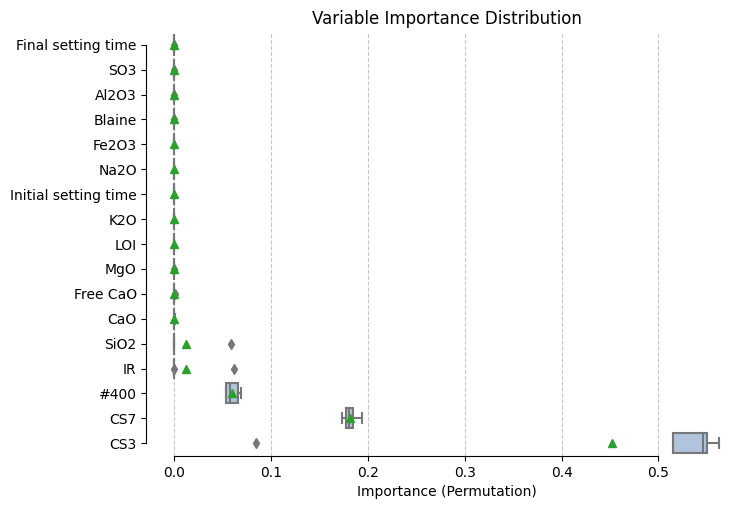

<IPython.core.display.Javascript object>

In [53]:
# Convert lists to DataFrames
mdi_importances_df = pd.DataFrame(mdi_importances, columns=x.columns)
perm_importances_df = pd.DataFrame(perm_importances, columns=x.columns)


# Calculate the mean importance for each feature
mean_importances = perm_importances_df.mean().sort_values()

# Reorder the DataFrame columns based on mean importance
perm_importances_df = perm_importances_df[mean_importances.index]

perm_importances_df = perm_importances_df.rename(
    columns={"Loss on Ignition": "LOI", "Insoluble Residue": "IR"}
)


plt.figure(figsize=(10, 5.5))
sns.boxplot(
    data=perm_importances_df,
    orient="h",
    color="lightsteelblue",
    saturation=1,
    showmeans=True,
)
sns.despine(trim=True, left=False)
plt.xlabel("Importance (Permutation)")
plt.title("Variable Importance Distribution")
plt.grid(axis="x", linestyle="--", alpha=0.7)
plt.subplots_adjust(left=0.3)
plt.savefig(
    "ecics_cm_p_cs_tiss_random_forest_scpm_best_dist_var_perm_relevance.png",
    dpi=300,
    bbox_inches="tight",
)

# # Step 3: Reset all rcParams to their default values
plt.rcdefaults()

plt.show()

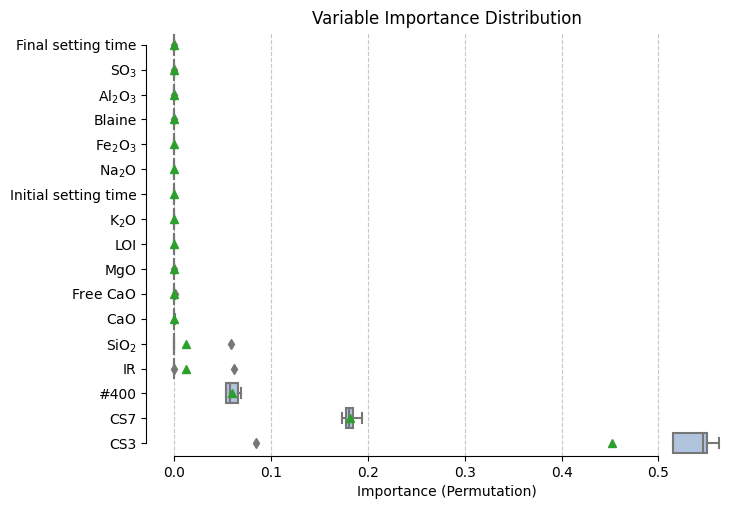

<IPython.core.display.Javascript object>

In [54]:
# Backup the original backend
original_backend = plt.get_backend()

# Update font settings to default
plt.rcParams.update(
    {
        "font.family": "sans-serif",
        "font.sans-serif": ["DejaVu Sans"],
        "font.size": 10,
        "text.usetex": False,  # Use MathText, not LaTeX
    }
)

# Convert chemical formulas using MathText syntax
perm_importances_df_plot = perm_importances_df.rename(
    columns={
        "K2O": r"$\mathrm{K_2O}$",
        "Free CaO": r"Free $\mathrm{CaO}$",
        "Total C2S": r"Total $\mathrm{C_2S}$",
        "Na2O": r"$\mathrm{Na_2O}$",
        "CaO": r"$\mathrm{CaO}$",
        "SiO2": r"$\mathrm{SiO_2}$",
        "MgO": r"$\mathrm{MgO}$",
        "Fe2O3": r"$\mathrm{Fe_2O_3}$",
        "Al2O3": r"$\mathrm{Al_2O_3}$",
        "Total C3S": r"Total $\mathrm{C_3S}$",
        "C3A": r"$\mathrm{C_3A}$",
        "C4AF": r"$\mathrm{C_4AF}$",
        "LOI": "LOI",
        "SO3": r"$\mathrm{SO_3}$",
        "Insoluble Residue": "IR",
    }
)

plt.figure(figsize=(10, 5.5))
sns.boxplot(
    data=perm_importances_df_plot,
    orient="h",
    color="lightsteelblue",
    saturation=1,
    showmeans=True,
)
sns.despine(trim=True, left=False)
plt.xlabel("Importance (Permutation)")
plt.title("Variable Importance Distribution")
plt.grid(axis="x", linestyle="--", alpha=0.7)
plt.subplots_adjust(left=0.3)
plt.savefig(
    "ecics_cm_p_cs_tiss_random_forest_scpm_best_dist_var_perm_relevance.png",
    dpi=300,
    bbox_inches="tight",
)


# Step 3: Reset all rcParams to their default values
matplotlib.rcParams.update(matplotlib.rcParamsDefault)
plt.rcdefaults()

# Switch back to the original backend
plt.switch_backend(original_backend)

plt.show()

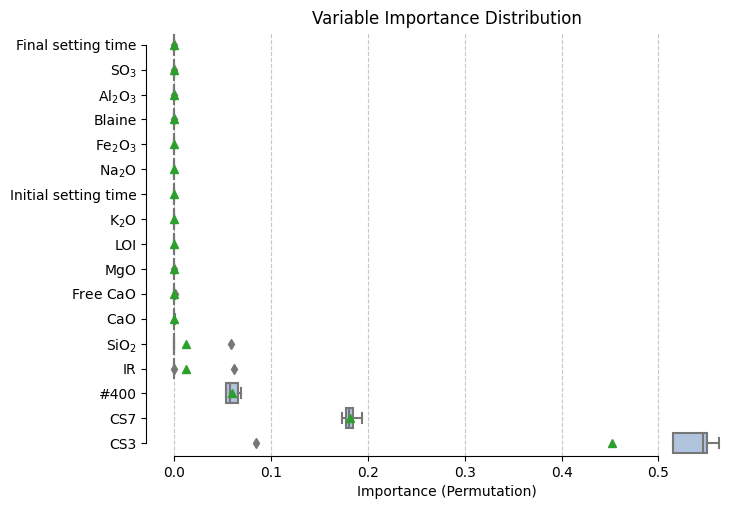

<IPython.core.display.Javascript object>

In [55]:
import matplotlib.ticker as mticker

# Step 1: Define a function to format the x-axis to one decimal place
def one_decimal(x, pos):
    return f'{x:.1f}'

# Backup the original backend
original_backend = plt.get_backend()

# Update font settings to default
plt.rcParams.update(
    {
        "font.family": "sans-serif",
        "font.sans-serif": ["DejaVu Sans"],
        "font.size": 10,
        "text.usetex": False,  # Use MathText, not LaTeX
    }
)

# Convert chemical formulas using MathText syntax
perm_importances_df_plot = perm_importances_df.rename(
    columns={
        "K2O": r"$\mathrm{K_2O}$",
        "Free CaO": r"Free $\mathrm{CaO}$",
        "Total C2S": r"Total $\mathrm{C_2S}$",
        "Na2O": r"$\mathrm{Na_2O}$",
        "CaO": r"$\mathrm{CaO}$",
        "SiO2": r"$\mathrm{SiO_2}$",
        "MgO": r"$\mathrm{MgO}$",
        "Fe2O3": r"$\mathrm{Fe_2O_3}$",
        "Al2O3": r"$\mathrm{Al_2O_3}$",
        "Total C3S": r"Total $\mathrm{C_3S}$",
        "C3A": r"$\mathrm{C_3A}$",
        "C4AF": r"$\mathrm{C_4AF}$",
        "LOI": "LOI",
        "SO3": r"$\mathrm{SO_3}$",
        "Insoluble Residue": "IR"
    }
)

plt.figure(figsize=(10, 5.5))
sns.boxplot(
    data=perm_importances_df_plot,
    orient="h",
    color="lightsteelblue",
    saturation=1,
    showmeans=True,
)
sns.despine(trim=True, left=False)
plt.xlabel("Importance (Permutation)")
plt.title("Variable Importance Distribution")
plt.grid(axis="x", linestyle="--", alpha=0.7)
plt.subplots_adjust(left=0.3)

# Step 2: Apply the formatter to the x-axis
ax = plt.gca()  # Get the current axis
ax.xaxis.set_major_formatter(mticker.FuncFormatter(one_decimal))

plt.savefig(
    "ecics_cm_p_cs_tiss_random_forest_scpm_best_dist_var_perm_relevance.png",
    dpi=300,
    bbox_inches="tight",
)

# Step 3: Reset all rcParams to their default values
matplotlib.rcParams.update(matplotlib.rcParamsDefault)
plt.rcdefaults()

# Switch back to the original backend
plt.switch_backend(original_backend)

plt.show()


In [56]:
perm_importances_df.describe().T

,count,mean,std,min,25%,50%,75%,max
Final setting time,5.0,-0.000133,0.000251,-0.000576,-0.000090,0.000000,0.000000,0.000000
SO3,5.0,-0.000034,0.000076,-0.000170,0.000000,0.000000,0.000000,0.000000
Al2O3,5.0,-0.000013,0.000029,-0.000066,0.000000,0.000000,0.000000,0.000000
Blaine,5.0,-0.000005,0.000010,-0.000023,0.000000,0.000000,0.000000,0.000000
Fe2O3,5.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
Na2O,5.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
Initial setting time,5.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
K2O,5.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
LOI,5.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
MgO,5.0,0.000002,0.000004,0.000000,0.000000,0.000000,0.000000,0.000009


<IPython.core.display.Javascript object>

In [57]:
train_data = df_pred[df_pred["SET"] == "TRAIN"]


<IPython.core.display.Javascript object>

In [58]:
train_data[(train_data["CS28"] >= 32) & (train_data["CS28"] <= 38)]["CS28"].describe().T

count    1868.000000
mean       34.849304
std         0.924802
min        32.299999
25%        34.400002
50%        34.700001
75%        35.299999
max        37.900002
Name: CS28, dtype: float64

<IPython.core.display.Javascript object>

In [59]:
train_data[(train_data["CS28"] >= 44) & (train_data["CS28"] <= 48)]["CS28"].describe().T

count    1773.000000
mean       45.219932
std         0.924780
min        44.000000
25%        44.500000
50%        45.000000
75%        45.799999
max        48.000000
Name: CS28, dtype: float64

<IPython.core.display.Javascript object>